# MCMCによる磁化推定の予備実験

## import

In [234]:
import numpy as np
import scipy.linalg
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colorbar as colorbars
import matplotlib.gridspec as gridspec
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import datetime
import os
import time
import pathlib
import sys
import uncertainties
import pickle
from uncertainties import ufloat
from tqdm.notebook import tqdm

import made
from made import MADE
import mcmc_function as mcmc
import ising_model as ising
from ising_model import Ising_model
import QAOA_function as qaoa
from QAOA_function import QAOA_ansatz

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['mathtext.fontset'] = 'cm'

seed = None
random.seed(seed)
rng = np.random.default_rng(seed)
#generator = torch.Generator().manual_seed(seed)

## 計算用関数の定義

### 磁化の自己相関関数計算

In [235]:
"""
def mcmc_magnetization_autocorrelation(spin_history, lag):
	mag_history = np.average(spin_history, axis=2)
	mag_mean = np.average(mag_history, axis=1)
	mag_acf = np.zeros((spin_history.shape[0], lag))
    
	for j in range(lag):
		if j == 0:
			mag_acf[:,j] = 1.0
		else:
			n = spin_history.shape[1] - j
			mag_acf[:,j] = np.average(mag_history[:,:n]*mag_history[:,-n:], axis=1) - mag_mean**2
	
	mag_acf /= np.tile(np.var(mag_history, axis=1).reshape(spin_history.shape[0],1), reps=(1,lag))
	
	return mag_acf
 
"""
def mcmc_magnetization_autocorrelation(spin_history, lag):
	mag_history = np.average(spin_history, axis=2)
	mag_mean = np.tile(np.average(mag_history, axis=1).reshape((mag_history.shape[0],1)), (1,spin_history.shape[1]))
	mag_acf = np.zeros((spin_history.shape[0], lag))
    
	for j in range(lag):
		if j == 0:
			mag_acf[:,j] = 1.0
		else:
			n = spin_history.shape[1] - j
			mag_acf[:,j] = np.average((mag_history[:,:n] - mag_mean[:,:n]) * (mag_history[:,-n:] - mag_mean[:,:n]), axis=1)
			mag_acf[:,j] /= np.sqrt(np.average((mag_history[:,:n] - mag_mean[:,:n])**2, axis=1) * np.average((mag_history[:,-n:] - mag_mean[:,:n])**2, axis=1))
	
	return mag_acf

### Rubinによる収束判定(予定)

## シミュレーション

### 変数設定

In [236]:
# instance
n_spin = 10
source_dir_name = 'data/instance_set_2024-0614-1705-31'
idx = rng.integers(0,100)
print(idx)

# QAOA
n_layers = 5
qaoa_init_para = [0.2705, -0.5899, 0.4803, -0.4492, 0.5074, -0.3559, 0.5646, -0.2643, 0.6397, -0.1291] #文献におけるSKmodelに対するQAOA(p=5)の固定角
qaoa_method = "BFGS"
qaoa_options = {"disp": False, "maxiter": 200, "gtol": 1e-6}

# MADE
n_train = 1000
n_test = int(n_train * 0.25)
hidden_layers = 2
batchsize = 8
lr = 0.005
n_epochs = 30

# mcmc
beta = 5.0
n_chain = 10
n_step = 10000
lag = 1000
burn_in = int(n_step * 0.1)
#burn_in = 0

48


### 計算実行

In [237]:
# import instance sets
fname_in = pathlib.Path(source_dir_name).joinpath('{0}_sites_instance_set.pickle'.format(n_spin))
with open(str(fname_in), 'rb') as f:
	instance_set = pickle.load(f)
# settings
hidden_size = int(2 * n_spin)

instance = instance_set[idx]

# optimize QAOA ansatz
prob_hamiltonian = instance.get_hamiltonian()
mixer_hamiltonian = qaoa.generate_X_mixer(n_spin)
qaoa_ansatz = QAOA_ansatz(prob_hamiltonian, mixer_hamiltonian, n_layers)
def qaoa_cost(para):
	return qaoa.cost_QAOA(prob_hamiltonian, qaoa_ansatz, para)
if qaoa_init_para == None:
	qaoa_para = [rng.uniform(0, 2*np.pi) for i in range(2*n_layers)]
else:
	qaoa_para = qaoa_init_para
qaoa_opt = scipy.optimize.minimize(qaoa_cost, qaoa_para, method=qaoa_method, options=qaoa_options)

# sampling from QAOA distribution
qaoa_opt_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, qaoa_opt.x, n_train+n_test) # optimize parameter
qaoa_fix_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, qaoa_init_para, n_train+n_test) # fixed angle

qaoa_opt_data_nd = np.array([qaoa.number_to_binary(qaoa_opt_data_idx[i], n_spin) for i in range(len(qaoa_opt_data_idx))], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！
qaoa_fix_data_nd = np.array([qaoa.number_to_binary(qaoa_fix_data_idx[i], n_spin) for i in range(len(qaoa_fix_data_idx))], dtype='float32')

qaoa_opt_data = torch.from_numpy(qaoa_opt_data_nd).to(dtype=torch.float32)
qaoa_opt_traindata, qaoa_opt_testdata = torch.utils.data.random_split(dataset=qaoa_opt_data, lengths=[n_train, n_test])

qaoa_fix_data = torch.from_numpy(qaoa_fix_data_nd).to(dtype=torch.float32)
qaoa_fix_traindata, qaoa_fix_testdata = torch.utils.data.random_split(dataset=qaoa_fix_data, lengths=[n_train, n_test])

qaoa_opt_testset = torch.utils.data.DataLoader(qaoa_opt_testdata, batch_size=batchsize, shuffle=False)
qaoa_opt_trainset = torch.utils.data.DataLoader(qaoa_opt_traindata, batch_size=batchsize, shuffle=True)

qaoa_fix_testset = torch.utils.data.DataLoader(qaoa_fix_testdata, batch_size=batchsize, shuffle=False)
qaoa_fix_trainset = torch.utils.data.DataLoader(qaoa_fix_traindata, batch_size=batchsize, shuffle=True)

# learn MADE by QAOA samples
hidden_list = [hidden_size for i in range(hidden_layers)]

model_qaoa_opt = MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
model_qaoa_fix = MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)

opt_qaoa_opt = torch.optim.Adam(model_qaoa_opt.parameters(), lr=lr, weight_decay=1e-4)
scheduler_qaoa_opt = torch.optim.lr_scheduler.StepLR(opt_qaoa_opt, step_size=45, gamma=0.1)

opt_qaoa_fix = torch.optim.Adam(model_qaoa_fix.parameters(), lr=lr, weight_decay=1e-4)
scheduler_qaoa_fix = torch.optim.lr_scheduler.StepLR(opt_qaoa_fix, step_size=45, gamma=0.1)

made.run_train(model_qaoa_opt, qaoa_opt_trainset, qaoa_opt_testset, n_epochs, opt_qaoa_opt, scheduler_qaoa_opt, seed)
made.run_train(model_qaoa_fix, qaoa_fix_trainset, qaoa_fix_testset, n_epochs, opt_qaoa_fix ,scheduler_qaoa_fix, seed)

# sampling to models and compute the probability of these outputs
opt_qaoa_made_outputs_nd = made.predict(model_qaoa_opt, n_step)
opt_qaoa_made_outputs_spin = np.array([made.binary_to_spin(opt_qaoa_made_outputs_nd[i]) for i in range(opt_qaoa_made_outputs_nd.shape[0])])
fix_qaoa_made_outputs_nd = made.predict(model_qaoa_fix, n_step)
fix_qaoa_made_outputs_spin = np.array([made.binary_to_spin(fix_qaoa_made_outputs_nd[i]) for i in range(fix_qaoa_made_outputs_nd.shape[0])])
opt_qaoa_made_log_prob = made.compute_log_prob(model_qaoa_opt, opt_qaoa_made_outputs_nd)
fix_qaoa_made_log_prob = made.compute_log_prob(model_qaoa_fix, fix_qaoa_made_outputs_nd)

# mcmc simulation
opt_qaoa_made_result = np.zeros((n_chain, n_step+1, n_spin), dtype=np.int8)
fix_qaoa_made_result = np.zeros((n_chain, n_step+1, n_spin), dtype=np.int8)
uniform_result = np.zeros((n_chain, n_step+1, n_spin), dtype=np.int8)
ssf_result = np.zeros((n_chain, n_step+1, n_spin), dtype=np.int8)

init_spin_idx_set = rng.choice(2**n_spin, n_chain, replace=False)
print(init_spin_idx_set)
for k in range(n_chain):
	init_spin = ising.number_to_spin(init_spin_idx_set[k], n_spin)
	opt_qaoa_made_result[k] = mcmc.neural_update_mcmc(init_spin, instance, model_qaoa_opt, opt_qaoa_made_outputs_spin, opt_qaoa_made_log_prob, beta, n_step, rng)[0]
	fix_qaoa_made_result[k] = mcmc.neural_update_mcmc(init_spin, instance, model_qaoa_fix, fix_qaoa_made_outputs_spin, fix_qaoa_made_log_prob, beta, n_step, rng)[0]
	uniform_result[k] = mcmc.uniform_update_mcmc(init_spin, instance, beta, n_step, rng)[0]
	ssf_result[k] = mcmc.ssf_update_mcmc(init_spin, instance, beta, n_step, rng)[0]
 
# acf for magentization
acf_history_opt_made = mcmc_magnetization_autocorrelation(opt_qaoa_made_result[:,burn_in:], lag)
acf_history_fix_made = mcmc_magnetization_autocorrelation(fix_qaoa_made_result[:,burn_in:], lag)
acf_history_uni = mcmc_magnetization_autocorrelation(uniform_result[:,burn_in:], lag)
acf_history_ssf = mcmc_magnetization_autocorrelation(ssf_result[:,burn_in:], lag)

[539 818 953 714 882 148 109 217 834 591]


## plot

### 磁化平均の推移

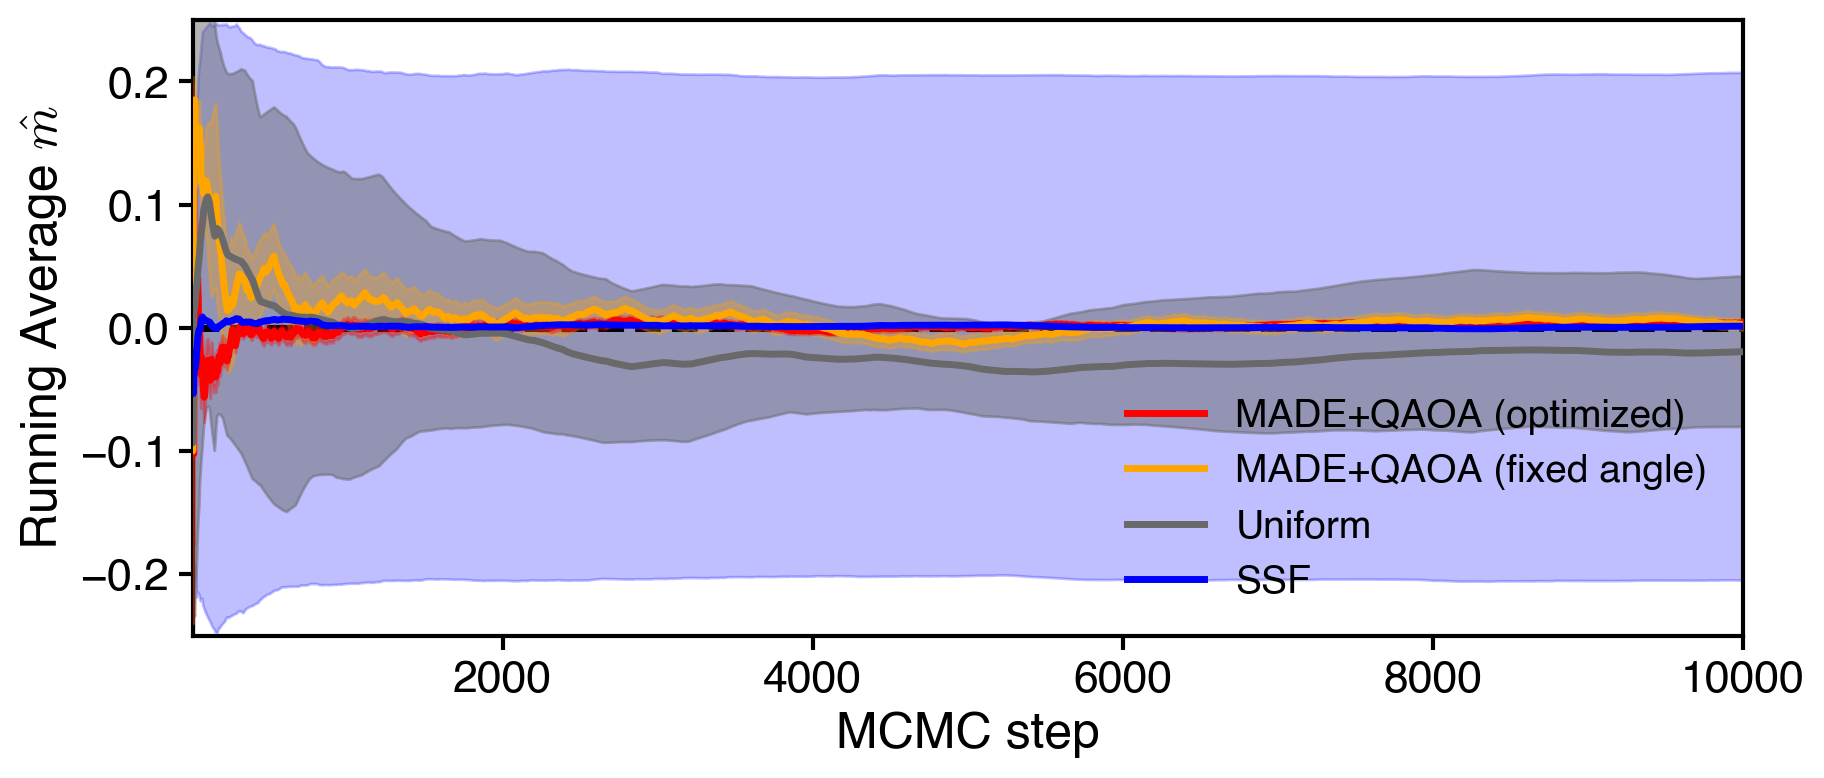

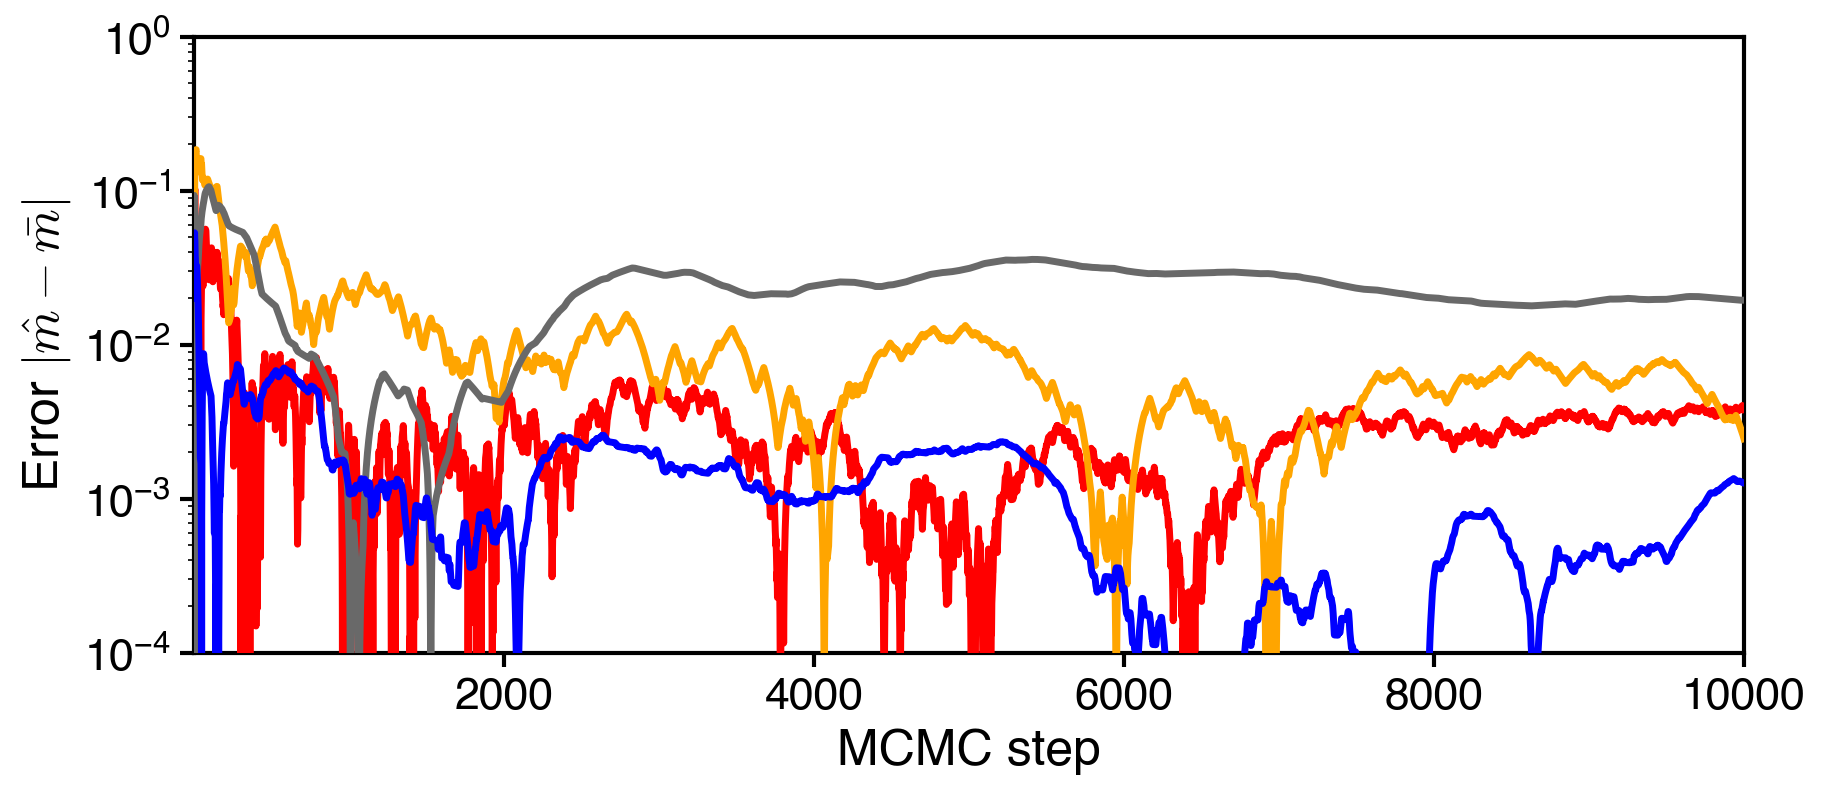

In [238]:
temp = np.arange(1, opt_qaoa_made_result.shape[1]+1)
normalize = np.tile(temp, (n_chain, 1))
true_val = 0.0

# 平均磁化
opt_qaoa_made_mag = np.average(opt_qaoa_made_result, axis=2)
opt_qaoa_made_mag_hist = np.cumsum(opt_qaoa_made_mag, axis=1) / normalize
opt_qaoa_made_mag_mean = np.average(opt_qaoa_made_mag_hist, axis=0)[0:n_step+1]
opt_qaoa_made_mag_std = np.std(opt_qaoa_made_mag_hist, axis=0, ddof=1)[0:n_step+1]

fix_qaoa_made_mag = np.average(fix_qaoa_made_result, axis=2)
fix_qaoa_made_mag_hist = np.cumsum(fix_qaoa_made_mag, axis=1) / normalize
fix_qaoa_made_mag_mean = np.average(fix_qaoa_made_mag_hist, axis=0)[0:n_step+1]
fix_qaoa_made_mag_std = np.std(fix_qaoa_made_mag_hist, axis=0, ddof=1)[0:n_step+1]

uniform_mag = np.average(uniform_result, axis=2)
uniform_mag_hist = np.cumsum(uniform_mag, axis=1) / normalize
uniform_mag_mean = np.average(uniform_mag_hist, axis=0)[0:n_step+1]
uniform_mag_std = np.std(uniform_mag_hist, axis=0, ddof=1)[0:n_step+1]

ssf_mag = np.average(ssf_result, axis=2)
ssf_mag_hist = np.cumsum(ssf_mag, axis=1) / normalize
ssf_mag_mean = np.average(ssf_mag_hist, axis=0)[0:n_step+1]
ssf_mag_std = np.std(ssf_mag_hist, axis=0, ddof=1)[0:n_step+1]
fig1, ax1 = plt.subplots(figsize=(10,4), dpi=200)

capsize = 4
markersize = 7.5
elinewidth = 2.5
capthick = 2.5
linewidth = 2.5
spines = 1.5
ax1.spines["top"].set_linewidth(spines)
ax1.spines["left"].set_linewidth(spines)
ax1.spines["bottom"].set_linewidth(spines)
ax1.spines["right"].set_linewidth(spines)

ax1.plot(np.arange(n_step+1), opt_qaoa_made_mag_mean, color='red', linewidth=linewidth, label='MADE+QAOA (optimized)', zorder=5)
ax1.fill_between(np.arange(n_step+1), opt_qaoa_made_mag_mean+opt_qaoa_made_mag_std, opt_qaoa_made_mag_mean-opt_qaoa_made_mag_std, color='red', alpha=0.3, zorder=4)

ax1.plot(np.arange(n_step+1), fix_qaoa_made_mag_mean, color='orange', linewidth=linewidth, label='MADE+QAOA (fixed angle)', zorder=5)
ax1.fill_between(np.arange(n_step+1), fix_qaoa_made_mag_mean+fix_qaoa_made_mag_std, fix_qaoa_made_mag_mean-fix_qaoa_made_mag_std, color='orange', alpha=0.3, zorder=3)

ax1.plot(np.arange(n_step+1), uniform_mag_mean, color='dimgrey', linewidth=linewidth, label='Uniform', zorder=5)
ax1.fill_between(np.arange(n_step+1), uniform_mag_mean+uniform_mag_std, uniform_mag_mean-uniform_mag_std, color='dimgrey', alpha=0.5, zorder=2)

ax1.plot(np.arange(n_step+1), ssf_mag_mean, color='blue', linewidth=linewidth, label='SSF', zorder=5)
ax1.fill_between(np.arange(n_step+1), ssf_mag_mean+ssf_mag_std, ssf_mag_mean-ssf_mag_std, color='blue', alpha=0.25, zorder=1)

ax1.axhline(true_val, color='black', linestyle='--', linewidth=linewidth)

ax1.set_xlim(1, n_step)
#ax1.set_xscale('log')
ax1.set_ylim(-0.25,0.25)
ax1.set_xlabel('MCMC step', fontsize=18)
ax1.set_ylabel(r'Running Average $\hat{m}$', fontsize=18)
ax1.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax1.tick_params(axis="x", which='major', width=1.5)
ax1.legend(fontsize=14, loc='lower right', frameon=False)

fig1_2, ax1_2 = plt.subplots(figsize=(10,4), dpi=200)

ax1_2.spines["top"].set_linewidth(spines)
ax1_2.spines["left"].set_linewidth(spines)
ax1_2.spines["bottom"].set_linewidth(spines)
ax1_2.spines["right"].set_linewidth(spines)

ax1_2.plot(np.arange(n_step+1), np.abs(opt_qaoa_made_mag_mean-true_val), color='red', linewidth=linewidth, label='MADE+QAOA (optimized)', zorder=5)
ax1_2.plot(np.arange(n_step+1), np.abs(fix_qaoa_made_mag_mean-true_val), color='orange', linewidth=linewidth, label='MADE+QAOA (fixed angle)', zorder=5)
ax1_2.plot(np.arange(n_step+1), np.abs(uniform_mag_mean-true_val), color='dimgrey', linewidth=linewidth, label='Uniform', zorder=5)
ax1_2.plot(np.arange(n_step+1), np.abs(ssf_mag_mean-true_val), color='blue', linewidth=linewidth, label='SSF', zorder=5)

ax1_2.set_yscale('log')
ax1_2.set_xlim(1, n_step)
#ax1_2.set_xscale('log')
ax1_2.set_ylim(1e-4, 1e0)
ax1_2.set_xlabel('MCMC step', fontsize=18)
ax1_2.set_ylabel(r'Error $|\hat{m} - \bar{m}|$', fontsize=18)
ax1_2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax1_2.tick_params(axis="x", which='major', width=1.5)
#ax1_2.legend(fontsize=14, loc='lower right', frameon=False)

#fig2.savefig("mag_est_result.svg", bbox_inches='tight')

### 磁化の自己相関関数の推移

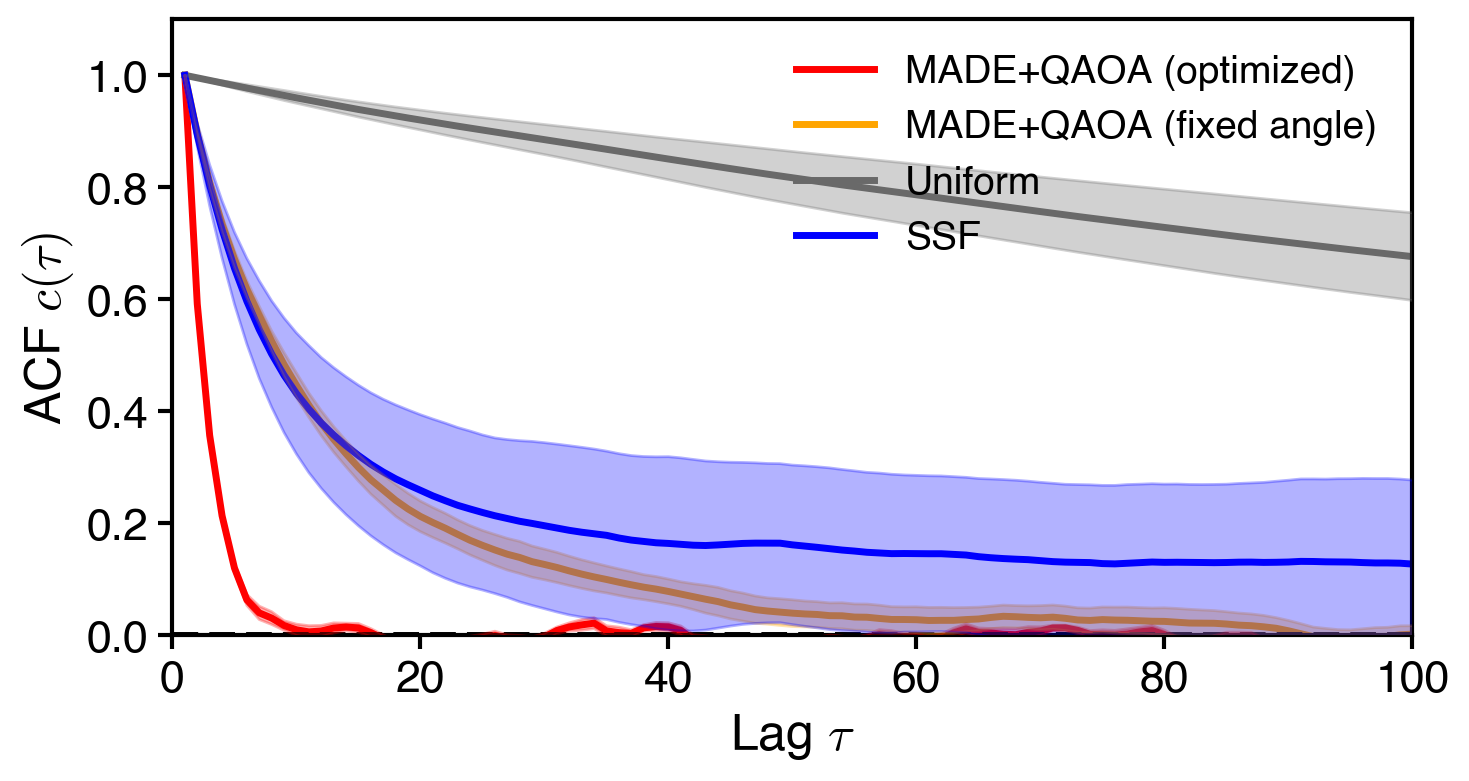

In [239]:
mag_acf_opt_made_ave = np.average(acf_history_opt_made, axis=0)
mag_acf_opt_made_std = np.std(acf_history_opt_made, axis=0)
mag_acf_fix_made_ave = np.average(acf_history_fix_made, axis=0)
mag_acf_fix_made_std = np.std(acf_history_fix_made, axis=0)
mag_acf_uni_ave = np.average(acf_history_uni, axis=0)
mag_acf_uni_std = np.std(acf_history_uni, axis=0)
mag_acf_ssf_ave = np.average(acf_history_ssf, axis=0)
mag_acf_ssf_std = np.std(acf_history_ssf, axis=0)

fig2, ax2 = plt.subplots(figsize=(8,4), dpi=200)

capsize = 4
markersize = 7.5
elinewidth = 2.5
capthick = 2.5
linewidth = 2.5
spines = 1.5
ax2.spines["top"].set_linewidth(spines)
ax2.spines["left"].set_linewidth(spines)
ax2.spines["bottom"].set_linewidth(spines)
ax2.spines["right"].set_linewidth(spines)

ax2.plot(np.arange(1, lag+1), mag_acf_opt_made_ave, color='red', linewidth=linewidth, label='MADE+QAOA (optimized)')
ax2.fill_between(np.arange(1, lag+1), mag_acf_opt_made_ave+mag_acf_opt_made_std, mag_acf_opt_made_ave-mag_acf_opt_made_std, color='red', alpha=0.3, zorder=4)
ax2.plot(np.arange(1, lag+1), mag_acf_fix_made_ave, color='orange', linewidth=linewidth, label='MADE+QAOA (fixed angle)')
ax2.fill_between(np.arange(1, lag+1), mag_acf_fix_made_ave+mag_acf_fix_made_std, mag_acf_fix_made_ave-mag_acf_fix_made_std, color='orange', alpha=0.3, zorder=4)
ax2.plot(np.arange(1, lag+1), mag_acf_uni_ave, color='dimgrey', linewidth=linewidth, label='Uniform')
ax2.fill_between(np.arange(1, lag+1), mag_acf_uni_ave+mag_acf_uni_std, mag_acf_uni_ave-mag_acf_uni_std, color='dimgrey', alpha=0.3, zorder=4)
ax2.plot(np.arange(1, lag+1), mag_acf_ssf_ave, color='blue', linewidth=linewidth, label='SSF')
ax2.fill_between(np.arange(1, lag+1), mag_acf_ssf_ave+mag_acf_ssf_std, mag_acf_ssf_ave-mag_acf_ssf_std, color='blue', alpha=0.3, zorder=4)

ax2.axhline(0.0, color='black', linestyle='--', linewidth=linewidth)

ax2.set_xlim(0,100)
ax2.set_xlabel(r'Lag $\tau$', fontsize=18)
ax2.set_ylim(0,1.1)
ax2.set_ylabel(r'ACF $c(\tau)$', fontsize=18)
ax2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax2.tick_params(axis="x", which='major', width=1.5)
ax2.legend(fontsize=14, loc='upper right', frameon=False)

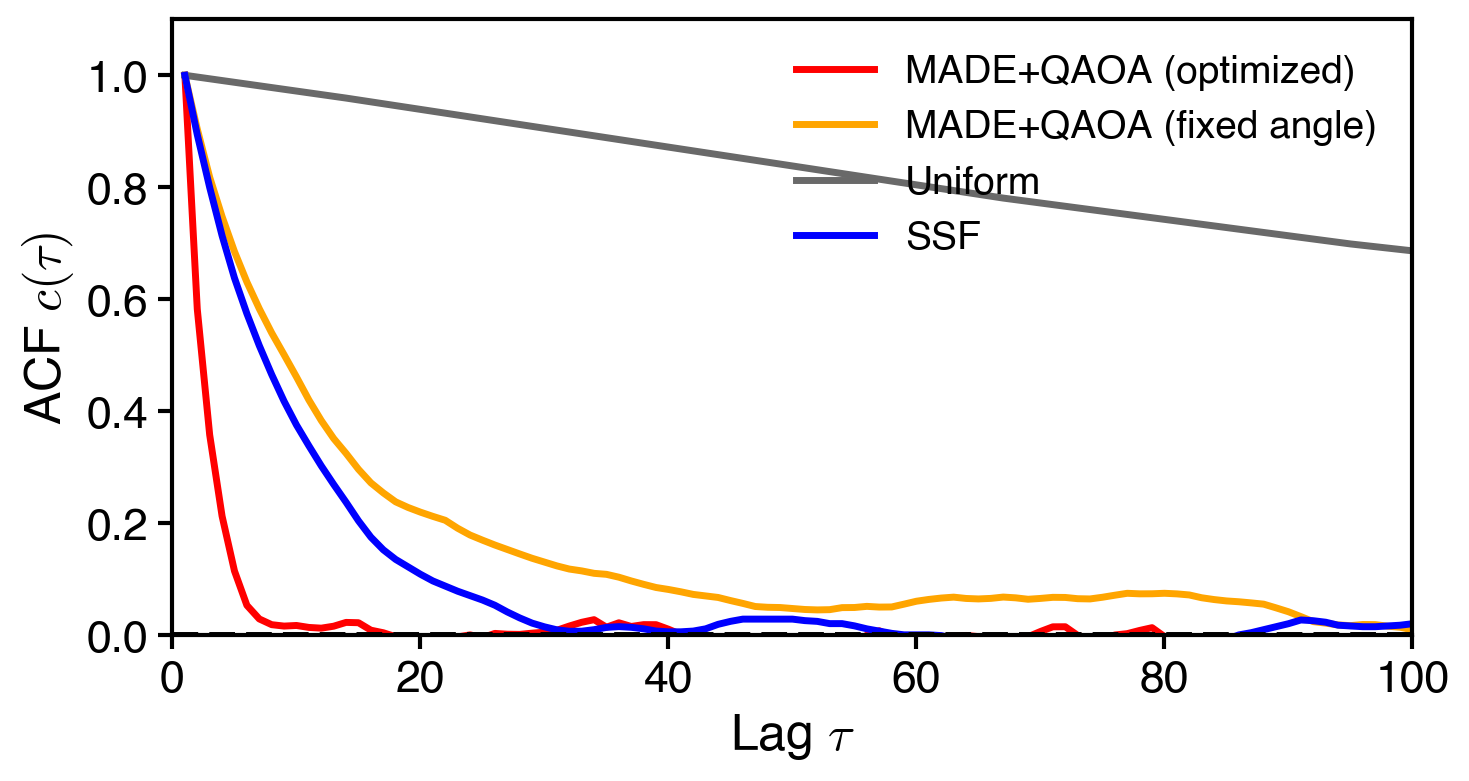

In [240]:
chain_idx = 8

fig2_1, ax2_1 = plt.subplots(figsize=(8,4), dpi=200)

capsize = 4
markersize = 7.5
elinewidth = 2.5
capthick = 2.5
linewidth = 2.5
spines = 1.5
ax2_1.spines["top"].set_linewidth(spines)
ax2_1.spines["left"].set_linewidth(spines)
ax2_1.spines["bottom"].set_linewidth(spines)
ax2_1.spines["right"].set_linewidth(spines)

ax2_1.plot(np.arange(1, lag+1), acf_history_opt_made[chain_idx], color='red', linewidth=linewidth, label='MADE+QAOA (optimized)')
ax2_1.plot(np.arange(1, lag+1), acf_history_fix_made[chain_idx], color='orange', linewidth=linewidth, label='MADE+QAOA (fixed angle)')
ax2_1.plot(np.arange(1, lag+1), acf_history_uni[chain_idx], color='dimgrey', linewidth=linewidth, label='Uniform')
ax2_1.plot(np.arange(1, lag+1), acf_history_ssf[chain_idx], color='blue', linewidth=linewidth, label='SSF')

ax2_1.axhline(0.0, color='black', linestyle='--', linewidth=linewidth)

ax2_1.set_xlim(0,100)
ax2_1.set_xlabel(r'Lag $\tau$', fontsize=18)
ax2_1.set_ylim(0,1.1)
ax2_1.set_ylabel(r'ACF $c(\tau)$', fontsize=18)
ax2_1.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax2_1.tick_params(axis="x", which='major', width=1.5)
ax2_1.legend(fontsize=14, loc='upper right', frameon=False)

### 積分緩和時間

[5.29844819e+00 2.35624535e+01 3.82436776e+02 9.98665319e+06
 1.95631316e+02]


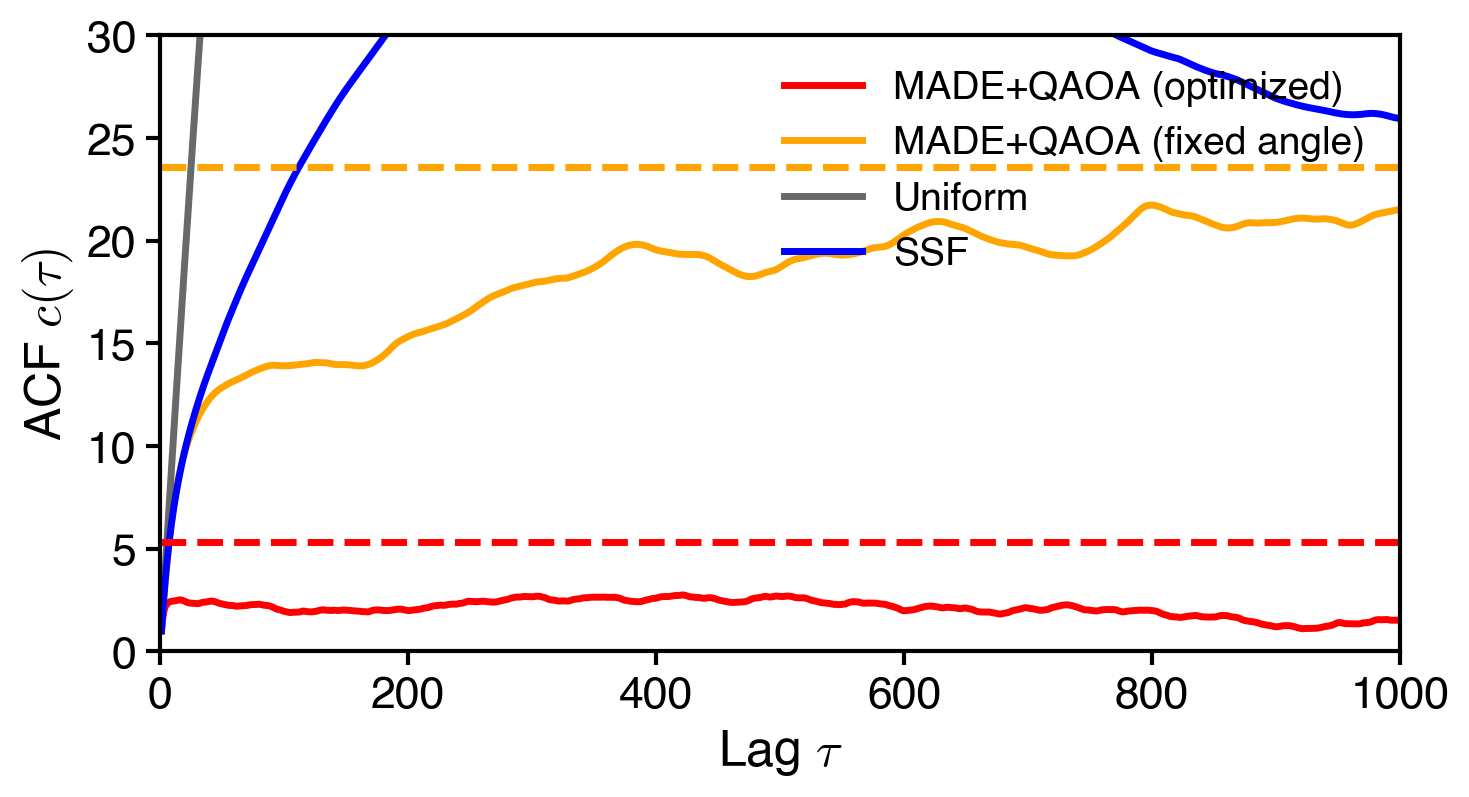

In [244]:
# calculate relaxation time from spectral gap
gap_data = np.load("result/spectral_gap/{0}_sites/beta_{1}.npy".format(n_spin, '{:.0e}'.format(beta)))
relax_time = -1.0 / np.log(1-gap_data[:,idx])

fig3, ax3 = plt.subplots(figsize=(8,4), dpi=200)

capsize = 4
markersize = 7.5
elinewidth = 2.5
capthick = 2.5
linewidth = 2.5
spines = 1.5
ax3.spines["top"].set_linewidth(spines)
ax3.spines["left"].set_linewidth(spines)
ax3.spines["bottom"].set_linewidth(spines)
ax3.spines["right"].set_linewidth(spines)

ax3.plot(np.arange(1, lag+1), np.cumsum(mag_acf_opt_made_ave), color='red', linewidth=linewidth, label='MADE+QAOA (optimized)')
ax3.plot(np.arange(1, lag+1), np.cumsum(mag_acf_fix_made_ave), color='orange', linewidth=linewidth, label='MADE+QAOA (fixed angle)')
ax3.plot(np.arange(1, lag+1), np.cumsum(mag_acf_uni_ave), color='dimgrey', linewidth=linewidth, label='Uniform')
ax3.plot(np.arange(1, lag+1), np.cumsum(mag_acf_ssf_ave), color='blue', linewidth=linewidth, label='SSF')

ax3.axhline(relax_time[0], color='red', linestyle='--', linewidth=linewidth)
ax3.axhline(relax_time[1], color='orange', linestyle='--', linewidth=linewidth)
ax3.axhline(relax_time[2], color='dimgrey', linestyle='--', linewidth=linewidth)
#ax3.axhline(relax_time[3], color='blue', linestyle='--', linewidth=linewidth)

ax3.set_xlim(0,lag)
ax3.set_ylim(0,30)
#ax3.set_yscale('log')
ax3.set_xlabel(r'Lag $\tau$', fontsize=18)
ax3.set_ylabel(r'ACF $c(\tau)$', fontsize=18)
ax3.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax3.tick_params(axis="x", which='major', width=1.5)
ax3.legend(fontsize=14, loc='upper right', frameon=False)

print(relax_time)

### 特定chainの状態遷移

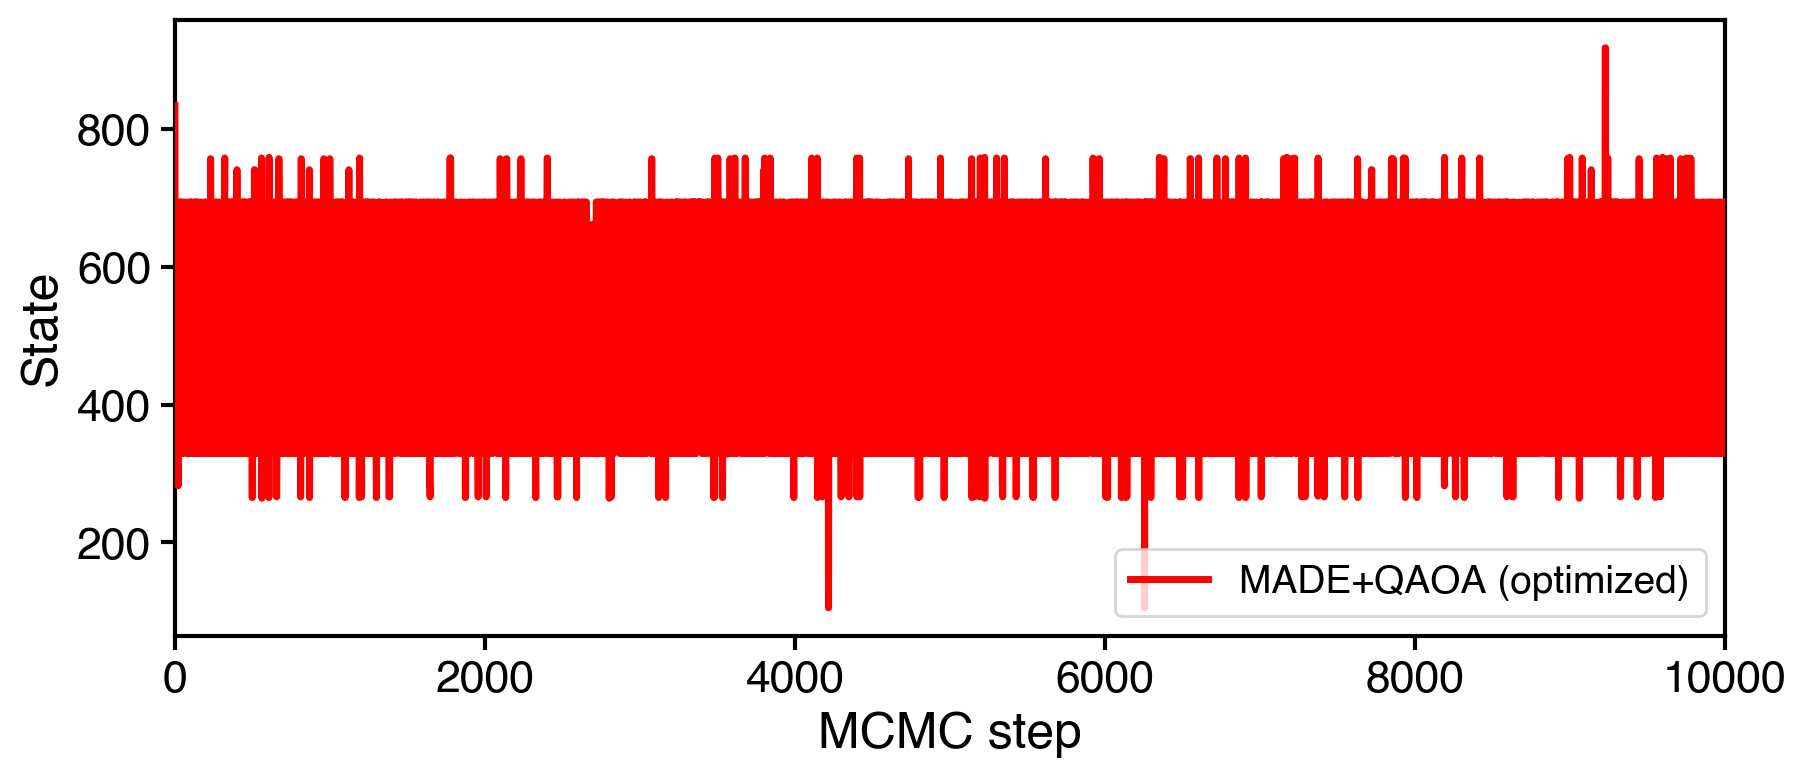

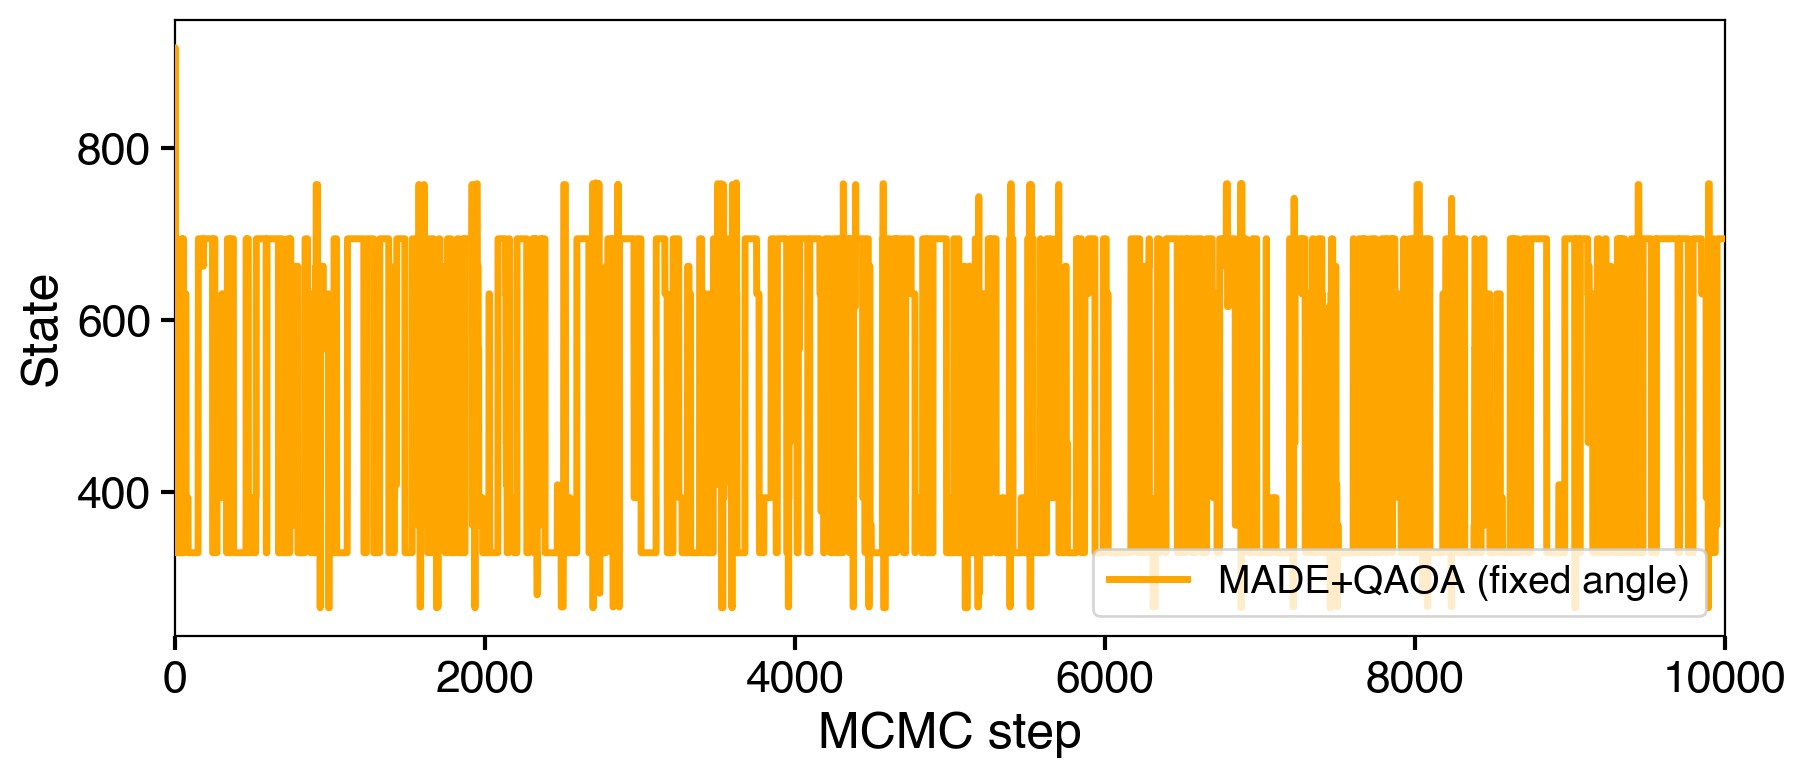

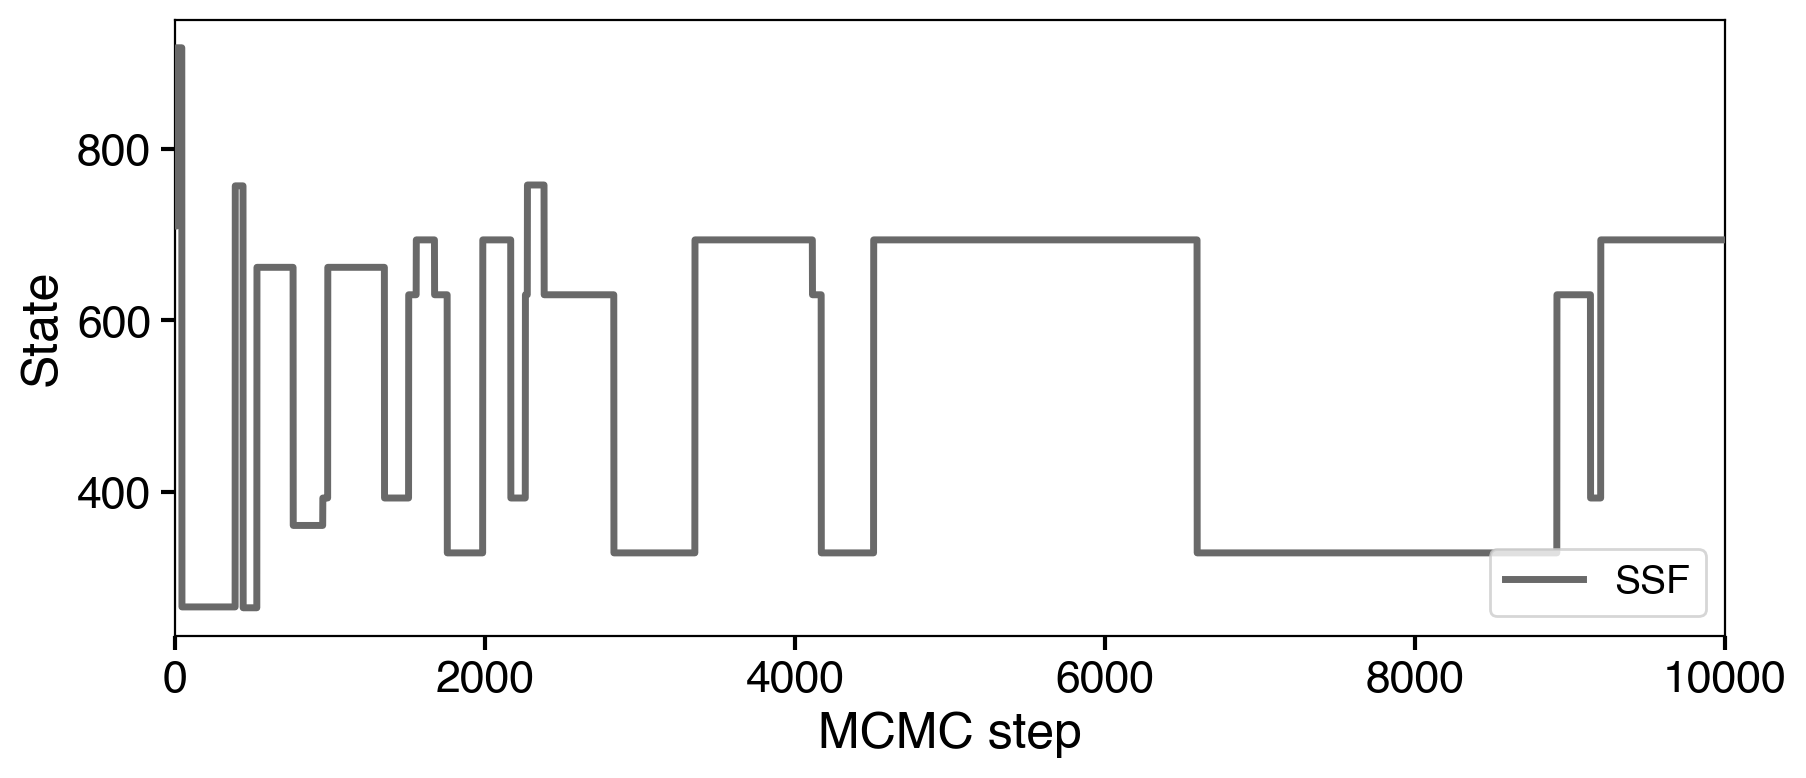

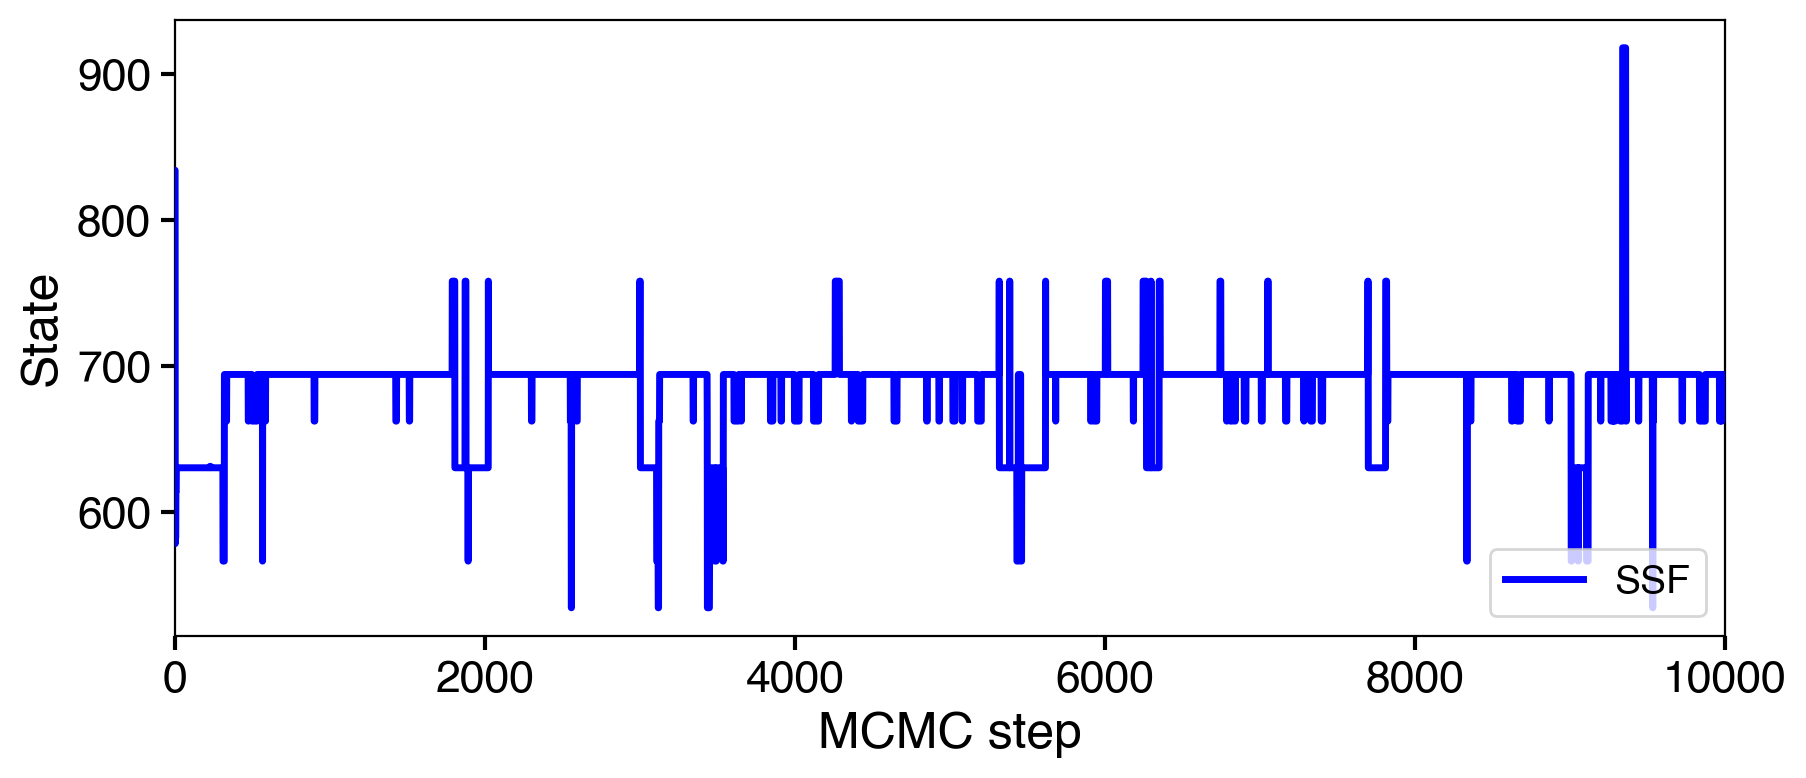

In [242]:
opt_state_hist = np.array([ising.spin_to_number(opt_qaoa_made_result[chain_idx,i]) for i in range(n_step+1)])
fix_state_hist = np.array([ising.spin_to_number(fix_qaoa_made_result[chain_idx,i]) for i in range(n_step+1)])
uni_state_hist = np.array([ising.spin_to_number(uniform_result[chain_idx,i]) for i in range(n_step+1)])
ssf_state_hist = np.array([ising.spin_to_number(ssf_result[chain_idx,i]) for i in range(n_step+1)])

fig3_2, ax3_2 = plt.subplots(figsize=(10,4), dpi=200)

ax3_2.spines["top"].set_linewidth(spines)
ax3_2.spines["left"].set_linewidth(spines)
ax3_2.spines["bottom"].set_linewidth(spines)
ax3_2.spines["right"].set_linewidth(spines)

ax3_2.plot(np.arange(n_step+1), opt_state_hist, color='red', linewidth=linewidth, label='MADE+QAOA (optimized)', zorder=5)

ax3_2.set_xlim(0, n_step)
ax3_2.set_xlabel('MCMC step', fontsize=18)
ax3_2.set_ylabel('State', fontsize=18)
ax3_2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax3_2.tick_params(axis="x", which='major', width=1.5)
ax3_2.legend(fontsize=14, loc='lower right', frameon=True)

fig3_3, ax3_3 = plt.subplots(figsize=(10,4), dpi=200)

ax3_3.plot(np.arange(n_step+1), fix_state_hist, color='orange', linewidth=linewidth, label='MADE+QAOA (fixed angle)', zorder=5)

ax3_3.set_xlim(0, n_step)
ax3_3.set_xlabel('MCMC step', fontsize=18)
ax3_3.set_ylabel('State', fontsize=18)
ax3_3.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax3_3.tick_params(axis="x", which='major', width=1.5)
ax3_3.legend(fontsize=14, loc='lower right', frameon=True)

fig3_1, ax3_1 = plt.subplots(figsize=(10,4), dpi=200)

ax3_1.plot(np.arange(n_step+1), uni_state_hist, color='dimgrey', linewidth=linewidth, label='SSF', zorder=5)

ax3_1.set_xlim(0, n_step)
ax3_1.set_xlabel('MCMC step', fontsize=18)
ax3_1.set_ylabel('State', fontsize=18)
ax3_1.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax3_1.tick_params(axis="x", which='major', width=1.5)
ax3_1.legend(fontsize=14, loc='lower right', frameon=True)

fig3_4, ax3_4 = plt.subplots(figsize=(10,4), dpi=200)

ax3_4.plot(np.arange(n_step+1), ssf_state_hist, color='blue', linewidth=linewidth, label='SSF', zorder=5)

ax3_4.set_xlim(0, n_step)
ax3_4.set_xlabel('MCMC step', fontsize=18)
ax3_4.set_ylabel('State', fontsize=18)
ax3_4.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax3_4.tick_params(axis="x", which='major', width=1.5)
ax3_4.legend(fontsize=14, loc='lower right', frameon=True)